In [12]:
import itertools

import numpy as np
import pandas as pd
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical, Sequence
from matplotlib import pyplot as plt
from skimage.color import gray2rgb
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
% matplotlib inline
from keras_vggface import VGGFace



In [13]:
class Restnet50Sequence(Sequence):
    def __init__(self, x_set, y_set, batch_size=16):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([
            resize(img, (200, 200))
            for img in batch_x]), np.array(batch_y)

In [5]:
CLASS_MODE = 0
# EMOTIONS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
EMOTIONS = [ 'False', 'True']
LEARNING_RATE = 0.0001
DELTA = 0.00001

In [6]:
def load(mode=0):
    file = ['fer2013/training.csv',
            'fer2013/publictest.csv',
            'fer2013/privatetest.csv']
    data = pd.read_csv(file[mode])

    pixels = data['pixels'].apply(
        lambda img: np.fromstring(img, sep=' '))

    X = np.vstack(pixels.values)
    X = X.astype('float32')

    X /= 255

    X = gray2rgb(X)
    X = X.reshape(-1, 48, 48, 3)

    y = data['emotion'].values
    y = y.astype(np.int)

    return X, y

In [7]:
def class_func(value, good_class):
    if value == good_class:
        return 1
    else:
        return 0

In [8]:
x_eval, y_eval = load(mode=2)
vfunc = np.vectorize(class_func)
y_eval = vfunc(y_eval, CLASS_MODE)
y_eval = to_categorical(y_eval)
test_generator = Restnet50Sequence(x_eval, y_eval, 16)

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
model_vgg16_conv = VGG16(include_top=False)

input = Input(shape=(48, 48, 3), name='image_input')

output_vgg16_conv = model_vgg16_conv(input)

x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(2, activation='softmax', name='predictions')(x)

model = Model(inputs=input, outputs=x)

optimizer = Adam(lr=LEARNING_RATE, decay=DELTA)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:

vgg_model = VGGFace(model='resnet50', include_top=False,
                    input_shape=(200, 200, 3))
print(vgg_model)
last_layer = vgg_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
out = Dense(2, activation='softmax', name='classifier')(x)
model = Model(vgg_model.input, out)

optimizer = Adam(lr=LEARNING_RATE, decay=DELTA)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', metrics=['accuracy'])

/home/mandark/.conda/envs/tf1.7/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/home/mandark/.conda/envs/tf1.7/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[0 0 0 ... 0 0 0]
Normalized confusion matrix
[[0.73466753 0.26533247]
 [0.87576375 0.12423625]]


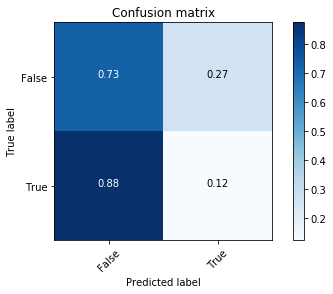

[[2276  822]
 [ 430   61]]


In [23]:
model.load_weights('binary_class_resnet_6/model.h5')
# predictions = model.predict(x_eval)
predictions = model.predict_generator(test_generator, use_multiprocessing=True)
predicted_class = np.argmax(predictions, axis=1)
true_class = np.argmax(y_eval, axis=1)
cm = confusion_matrix(true_class, predicted_class)
print(predicted_class)
plot_confusion_matrix(cm, classes=EMOTIONS, normalize=True)
plt.show()
print(cm)


Normalized confusion matrix
[[0.97901872 0.02098128]
 [0.95723014 0.04276986]]


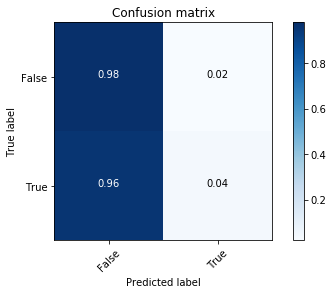

[[3033   65]
 [ 470   21]]
